# Expert Activation Pattern Analysis

**Goal**: Analyze MoE expert activation patterns across 5 domains to identify:
1. Domain-specific expert specialization
2. Temporal correlation patterns
3. Layer-wise behavior differences
4. Expert usage distributions

**Data**: 5 domains × 100 tokens × 72 MoE ops/token × 4 experts/op = 144,000 expert activations

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from scipy import stats
from scipy.stats import entropy

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Data path - CORRECTED
DATA_DIR = Path('../../expert-analysis-1')

print("Loaded libraries successfully!")

Loaded libraries successfully!


## Part 1: Data Loading

Load all expert activations from 5 domains into a structured DataFrame.

In [2]:
def extract_expert_activations(domain_path):
    """
    Extract all expert activations from a domain.
    
    Returns: List of dicts with columns:
        - domain: str
        - token_id: int
        - layer_id: int
        - component: str (ffn_down, ffn_gate, ffn_up)
        - expert_id: int (0-31)
        - position: int (0-3, which of top-4)
    """
    domain_name = domain_path.name
    activations = []
    
    # Load all 100 token traces
    for token_id in range(100):
        token_file = domain_path / 'traces' / f'token-{token_id:05d}.json'
        
        if not token_file.exists():
            continue
            
        with open(token_file) as f:
            data = json.load(f)
        
        # Extract MUL_MAT_ID operations (MoE routing)
        for entry in data['entries']:
            if entry['operation_type'] != 'MUL_MAT_ID' or not entry['expert_ids']:
                continue
            
            layer_id = entry['layer_id']
            
            # Identify component from destination name - FIXED
            dst_name = entry['dst_name']
            if 'ffn_moe_down' in dst_name:
                component = 'ffn_down'
            elif 'ffn_moe_gate' in dst_name:
                component = 'ffn_gate'
            elif 'ffn_moe_up' in dst_name:
                component = 'ffn_up'
            else:
                component = 'unknown'
            
            # Record each selected expert (top-4)
            for position, expert_id in enumerate(entry['expert_ids'][:4]):
                activations.append({
                    'domain': domain_name,
                    'token_id': token_id,
                    'layer_id': layer_id,
                    'component': component,
                    'expert_id': expert_id,
                    'position': position  # 0=top choice, 3=4th choice
                })
    
    return activations

# Load all domains
print("Loading expert activations from all domains...")
all_activations = []

domains = ['domain-1-code', 'domain-2-math', 'domain-3-creative', 
           'domain-4-factual', 'domain-5-mixed']

for domain_name in domains:
    domain_path = DATA_DIR / domain_name
    print(f"  Loading {domain_name}...")
    activations = extract_expert_activations(domain_path)
    all_activations.extend(activations)
    print(f"    ✓ {len(activations):,} activations")

# Convert to DataFrame
df = pd.DataFrame(all_activations)

print(f"\n✓ Total activations loaded: {len(df):,}")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Loading expert activations from all domains...
  Loading domain-1-code...
    ✓ 29,088 activations
  Loading domain-2-math...
    ✓ 29,088 activations
  Loading domain-3-creative...
    ✓ 29,088 activations
  Loading domain-4-factual...
    ✓ 29,088 activations
  Loading domain-5-mixed...
    ✓ 29,088 activations

✓ Total activations loaded: 145,440

DataFrame shape: (145440, 6)

First few rows:


,domain,token_id,layer_id,component,expert_id,position
0,domain-1-code,0,0,ffn_gate,9,0
1,domain-1-code,0,0,ffn_gate,5,1
2,domain-1-code,0,0,ffn_gate,24,2
3,domain-1-code,0,0,ffn_gate,3,3
4,domain-1-code,0,0,ffn_up,9,0
5,domain-1-code,0,0,ffn_up,5,1
6,domain-1-code,0,0,ffn_up,24,2
7,domain-1-code,0,0,ffn_up,3,3
8,domain-1-code,0,0,ffn_down,9,0
9,domain-1-code,0,0,ffn_down,5,1


## Part 2: Basic Statistics

Understand the dataset structure and distributions.

In [ ]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print(f"\nTotal expert activations: {len(df):,}")
print(f"Domains: {df['domain'].nunique()}")
print(f"Layers: {df['layer_id'].nunique()} (IDs: {df['layer_id'].min()}-{df['layer_id'].max()})")
print(f"Components: {df['component'].unique()}")
print(f"Expert IDs: {df['expert_id'].nunique()} (range: {df['expert_id'].min()}-{df['expert_id'].max()})")
print(f"Tokens per domain: {df.groupby('domain')['token_id'].nunique().iloc[0]}")

# Activations per domain
print("\nActivations per domain:")
print(df.groupby('domain').size())

# Activations per layer
print("\nActivations per layer:")
layer_counts = df.groupby('layer_id').size()
print(f"  Min: {layer_counts.min()} (Layer {layer_counts.idxmin()})")
print(f"  Max: {layer_counts.max()} (Layer {layer_counts.idxmax()})")
print(f"  Mean: {layer_counts.mean():.0f}")

DATASET OVERVIEW

Total expert activations: 145,440
Domains: 5
Layers: 24 (IDs: 0-23)
Components: <StringArray>
['ffn_gate', 'ffn_up', 'ffn_down']
Length: 3, dtype: str
Expert IDs: 32 (range: 0-31)
Tokens per domain: 100

Activations per domain:
domain
domain-1-code        29088
domain-2-math        29088
domain-3-creative    29088
domain-4-factual     29088
domain-5-mixed       29088
dtype: int64

Activations per layer:
  Min: 6060 (Layer 0)
  Max: 6060 (Layer 0)
  Mean: 6060


## Part 3: Domain Comparison - First Look

**Question**: Which experts are hot in each domain?

Start with **ONE layer, ONE component** to see if domain clustering exists.

Layer 0, Component: ffn_down
Total activations: 2,020
Activations per domain: 404

Frequency matrix (percentages):
expert_id                 0         1         2         3         4   \
domain                                                                 
domain-1-code       1.237624  4.207921  2.970297  1.732673  6.435644   
domain-2-math       1.980198  4.455446  3.465347  3.465347  1.237624   
domain-3-creative   3.465347  3.712871  5.198020  0.742574  3.217822   
domain-4-factual   11.138614  3.960396  2.722772  3.465347  2.722772   
domain-5-mixed      0.495050  1.980198  6.683168  1.237624  5.693069   

expert_id                5         6         7         8         9   ...  \
domain                                                               ...   
domain-1-code      2.475248  0.742574  3.465347  2.970297  5.445545  ...   
domain-2-math      2.970297  1.980198  2.970297  3.217822  4.455446  ...   
domain-3-creative  0.495050  1.980198  3.465347  2.227723  7.178218  ...   


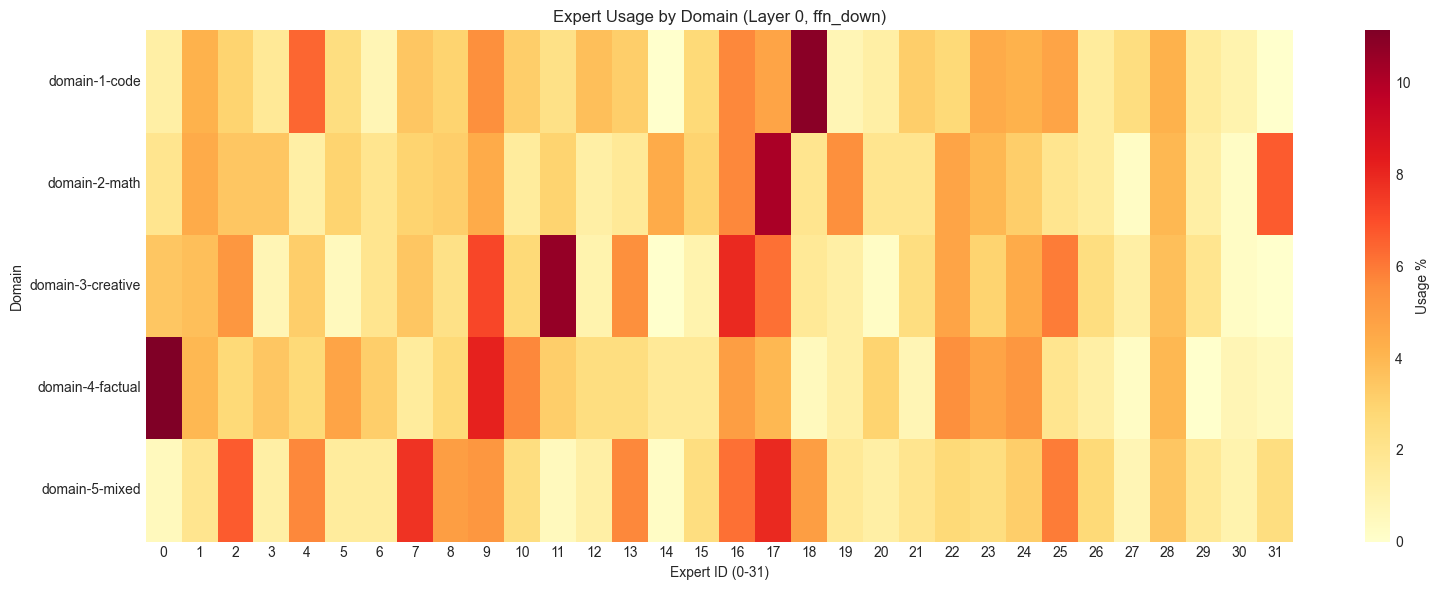


Most used experts per domain:
  domain-1-code: Experts [18, 4, 16, 9, 17] (33.2% of usage)
  domain-2-math: Experts [17, 31, 16, 19, 22] (32.7% of usage)
  domain-3-creative: Experts [11, 16, 9, 17, 25] (37.9% of usage)
  domain-4-factual: Experts [0, 9, 10, 22, 24] (35.6% of usage)
  domain-5-mixed: Experts [17, 7, 2, 16, 25] (34.4% of usage)


In [5]:
# Focus on Layer 0, ffn_down component
layer_to_analyze = 0
component_to_analyze = 'ffn_down'

# Filter data
subset = df[(df['layer_id'] == layer_to_analyze) & 
            (df['component'] == component_to_analyze)]

print(f"Layer {layer_to_analyze}, Component: {component_to_analyze}")
print(f"Total activations: {len(subset):,}")
print(f"Activations per domain: {len(subset) / 5:.0f}")

# Build Domain × Expert frequency matrix
freq_matrix = subset.pivot_table(
    index='domain',
    columns='expert_id',
    aggfunc='size',
    fill_value=0
)

# Convert to percentages (normalize by domain)
freq_matrix_pct = freq_matrix.div(freq_matrix.sum(axis=1), axis=0) * 100

print("\nFrequency matrix (percentages):")
print(freq_matrix_pct)

# Visualize
plt.figure(figsize=(16, 6))
sns.heatmap(freq_matrix_pct, annot=False, cmap='YlOrRd', 
            cbar_kws={'label': 'Usage %'},
            xticklabels=True, yticklabels=True)
plt.title(f'Expert Usage by Domain (Layer {layer_to_analyze}, {component_to_analyze})')
plt.xlabel('Expert ID (0-31)')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nMost used experts per domain:")
for domain in domains:
    top_experts = freq_matrix_pct.loc[domain].nlargest(5)
    expert_ids = top_experts.index.tolist()
    print(f"  {domain}: Experts {expert_ids} ({top_experts.values.sum():.1f}% of usage)")

## Part 4: Statistical Test for Domain Clustering

**Question**: Are the observed domain differences statistically significant?

Use Chi-square test for independence.

In [6]:
from scipy.stats import chi2_contingency

# Chi-square test on frequency matrix
chi2, p_value, dof, expected = chi2_contingency(freq_matrix)

print("Chi-Square Test for Independence")
print("=" * 60)
print(f"Null hypothesis: Expert selection is independent of domain")
print(f"\nChi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.001:
    print("\n✅ RESULT: HIGHLY SIGNIFICANT (p < 0.001)")
    print("   → Reject null hypothesis")
    print("   → Domains DO show different expert preferences!")
elif p_value < 0.05:
    print("\n✅ RESULT: SIGNIFICANT (p < 0.05)")
    print("   → Domains show different patterns")
else:
    print("\n❌ RESULT: NOT SIGNIFICANT")
    print("   → Expert selection appears independent of domain")

Chi-Square Test for Independence
Null hypothesis: Expert selection is independent of domain

Chi-square statistic: 599.52
p-value: 1.96e-63
Degrees of freedom: 124

✅ RESULT: HIGHLY SIGNIFICANT (p < 0.001)
   → Reject null hypothesis
   → Domains DO show different expert preferences!


## Part 5: Identify Domain-Specific vs General Experts

Classify each expert as:
- **Specialist**: Used heavily in one domain, rarely in others
- **Generalist**: Used similarly across all domains

In [7]:
# Calculate coefficient of variation for each expert across domains
expert_variance = freq_matrix.std(axis=0) / (freq_matrix.mean(axis=0) + 1e-10)

# High variance = specialist (used a lot in one domain, little in others)
# Low variance = generalist (used similarly across domains)

specialist_threshold = expert_variance.quantile(0.75)

specialists = expert_variance[expert_variance > specialist_threshold].index.tolist()
generalists = expert_variance[expert_variance < expert_variance.quantile(0.25)].index.tolist()

print("Expert Classification")
print("=" * 60)
print(f"\nSpecialists (high variance): {len(specialists)} experts")
print(f"  IDs: {specialists}")

print(f"\nGeneralists (low variance): {len(generalists)} experts")
print(f"  IDs: {generalists}")

# For each specialist, identify its preferred domain
print("\nSpecialist Expert → Preferred Domain:")
for expert_id in specialists:
    preferred_domain = freq_matrix[expert_id].idxmax()
    usage_pct = freq_matrix_pct.loc[preferred_domain, expert_id]
    print(f"  Expert {expert_id}: {preferred_domain} ({usage_pct:.1f}% of its usage)")

Expert Classification

Specialists (high variance): 8 experts
  IDs: [0, 11, 14, 18, 19, 20, 27, 31]

Generalists (low variance): 8 experts
  IDs: [1, 8, 9, 16, 22, 23, 24, 28]

Specialist Expert → Preferred Domain:
  Expert 0: domain-4-factual (11.1% of its usage)
  Expert 11: domain-3-creative (10.6% of its usage)
  Expert 14: domain-2-math (4.5% of its usage)
  Expert 18: domain-1-code (10.9% of its usage)
  Expert 19: domain-2-math (5.4% of its usage)
  Expert 20: domain-4-factual (3.0% of its usage)
  Expert 27: domain-1-code (2.5% of its usage)
  Expert 31: domain-2-math (6.7% of its usage)


## Part 6: All Layers Comparison

Repeat the analysis for all 24 layers to see if patterns differ by depth.

Domain Separation by Layer
    layer_id         chi2        p_value  avg_variance  significant
0          0   599.519564   1.958862e-63      0.000360         True
1          1   823.283254  1.191040e-103      0.000459         True
2          2   884.761452  4.254139e-115      0.000506         True
3          3  1490.089809  9.242198e-233      0.000989         True
4          4  1683.581281  1.511962e-271      0.000966         True
5          5  1117.937324  1.507315e-159      0.000812         True
6          6   752.717800   1.076883e-90      0.000406         True
7          7   866.862650  9.451156e-112      0.000478         True
8          8  1156.437161  5.745733e-171      0.000775         True
9          9  1619.108540  7.804673e-261      0.001157         True
10        10  2477.757101   0.000000e+00      0.001696         True
11        11  2388.701659   0.000000e+00      0.001756         True
12        12  2247.303572   0.000000e+00      0.001404         True
13        13  2264.16

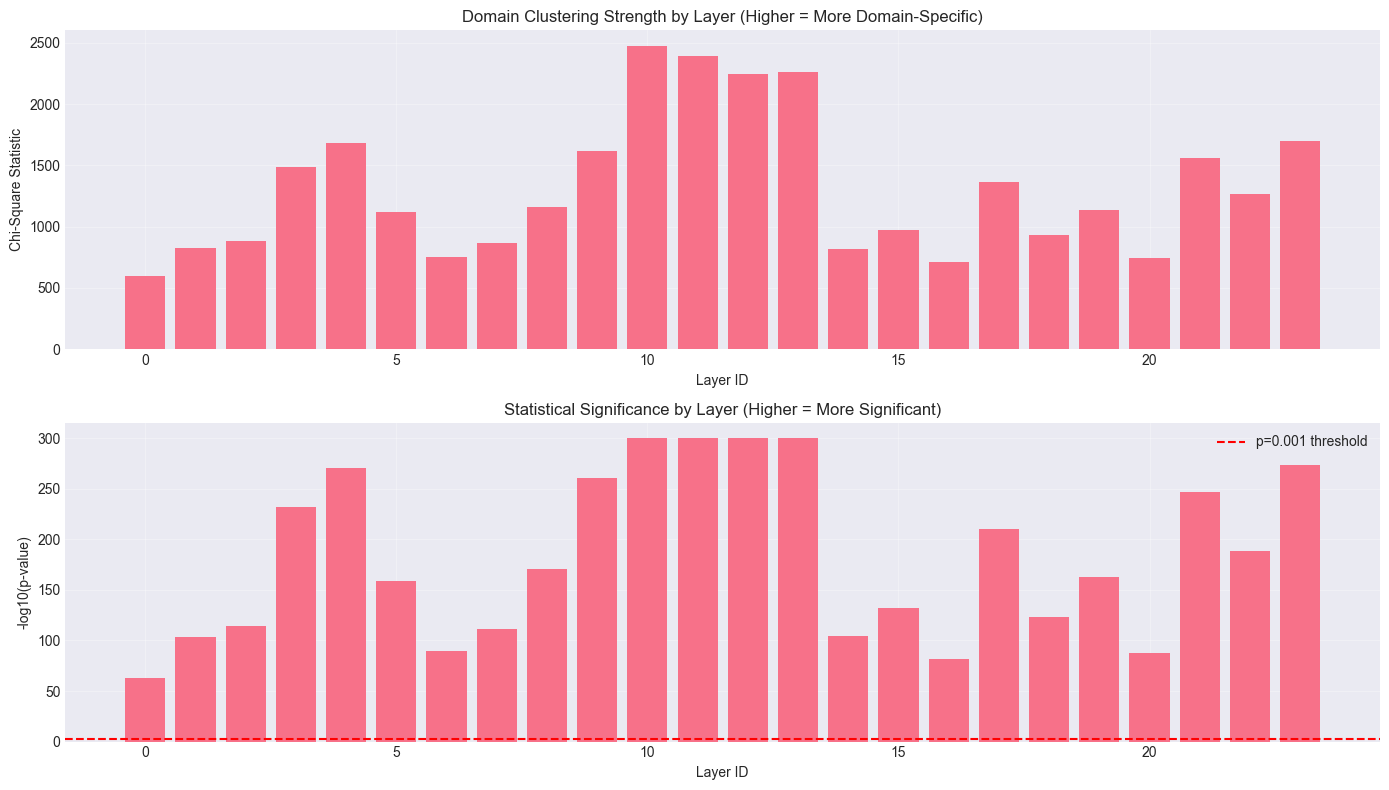


Most domain-specific layers: [10, 11, 13, 12, 23]


In [8]:
# For each layer, calculate domain separation metric
layer_separation = []

for layer_id in range(24):
    layer_data = df[(df['layer_id'] == layer_id) & 
                    (df['component'] == 'ffn_down')]
    
    if len(layer_data) == 0:
        continue
    
    # Build frequency matrix for this layer
    layer_freq = layer_data.pivot_table(
        index='domain',
        columns='expert_id',
        aggfunc='size',
        fill_value=0
    )
    
    # Chi-square test
    chi2, p_value, _, _ = chi2_contingency(layer_freq)
    
    # Variance metric (how different are domains?)
    # Normalize by domain first
    layer_freq_norm = layer_freq.div(layer_freq.sum(axis=1), axis=0)
    
    # Calculate variance across domains for each expert, then average
    avg_variance = layer_freq_norm.var(axis=0).mean()
    
    layer_separation.append({
        'layer_id': layer_id,
        'chi2': chi2,
        'p_value': p_value,
        'avg_variance': avg_variance,
        'significant': p_value < 0.001
    })

sep_df = pd.DataFrame(layer_separation)

print("Domain Separation by Layer")
print("=" * 60)
print(sep_df.to_string())

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Chi-square statistic
axes[0].bar(sep_df['layer_id'], sep_df['chi2'])
axes[0].set_xlabel('Layer ID')
axes[0].set_ylabel('Chi-Square Statistic')
axes[0].set_title('Domain Clustering Strength by Layer (Higher = More Domain-Specific)')
axes[0].grid(True, alpha=0.3)

# Plot 2: P-value (log scale)
axes[1].bar(sep_df['layer_id'], -np.log10(sep_df['p_value'] + 1e-300))
axes[1].axhline(y=-np.log10(0.001), color='r', linestyle='--', label='p=0.001 threshold')
axes[1].set_xlabel('Layer ID')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_title('Statistical Significance by Layer (Higher = More Significant)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify most interesting layers
top_layers = sep_df.nlargest(5, 'chi2')['layer_id'].tolist()
print(f"\nMost domain-specific layers: {top_layers}")

## Part 7: Deep Dive - Most Interesting Layer

Pick the layer with strongest domain clustering and visualize all 3 components.

Analyzing Layer 10 in detail...


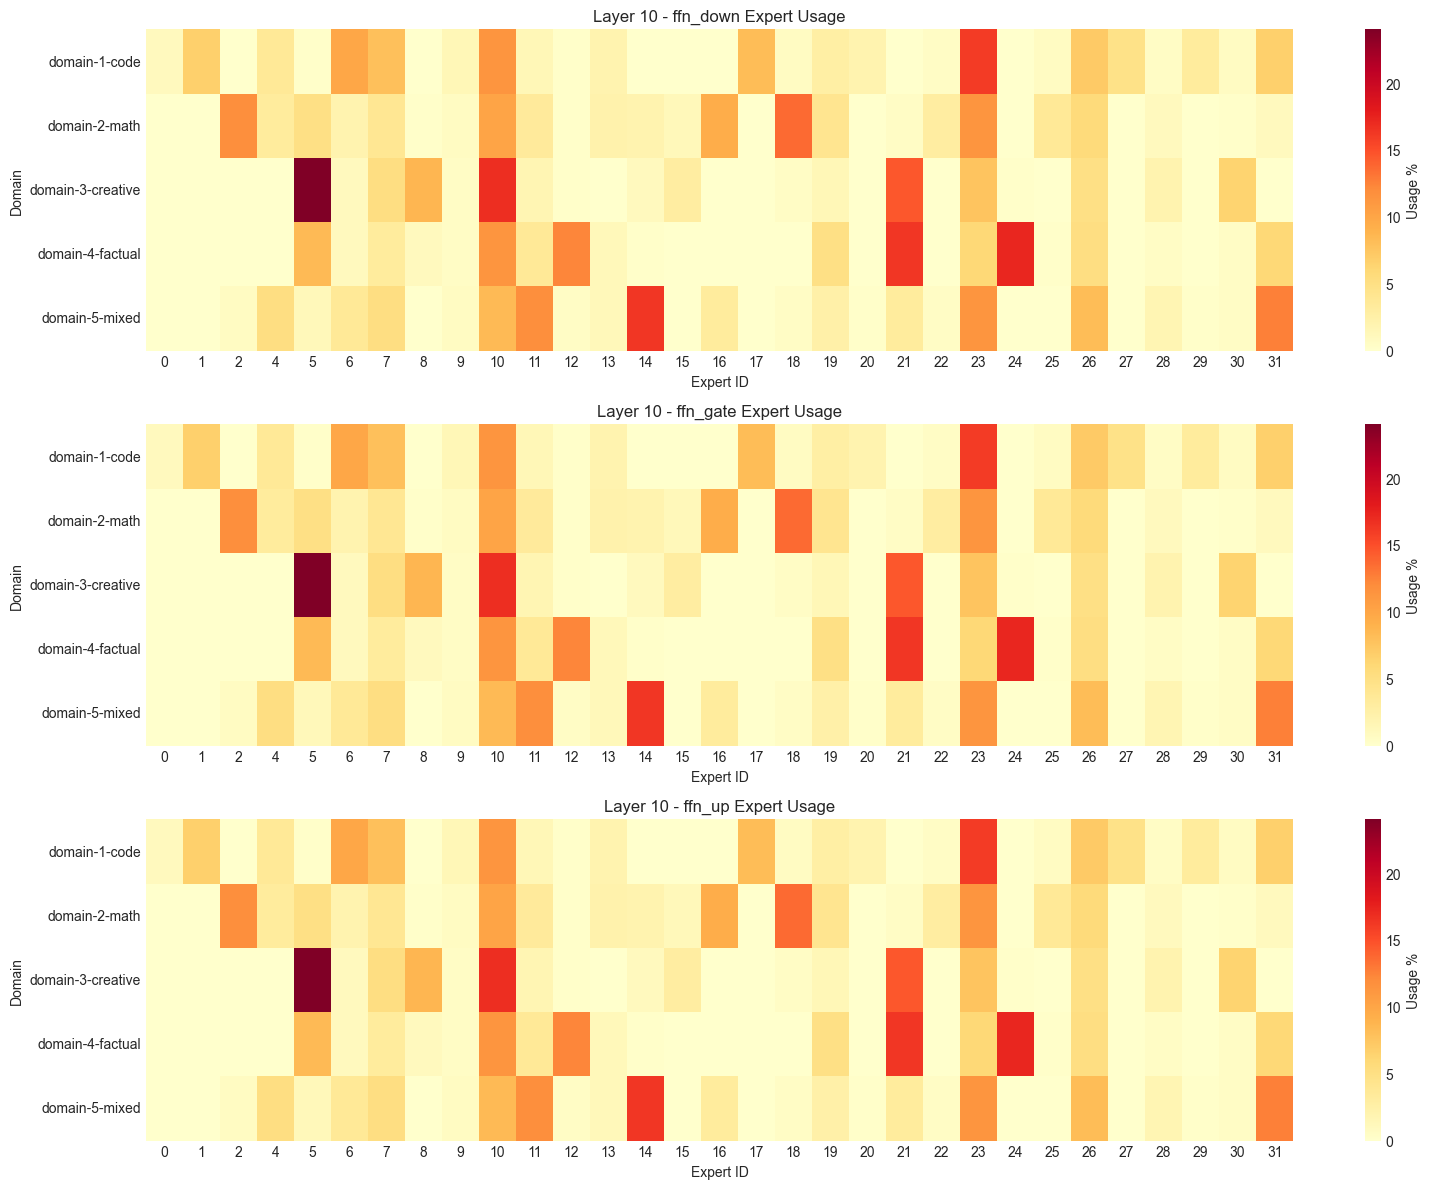


✓ Saved figure to outputs/figures/


In [9]:
interesting_layer = top_layers[0]

print(f"Analyzing Layer {interesting_layer} in detail...")

# Create 3 heatmaps (one per component)
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
components = ['ffn_down', 'ffn_gate', 'ffn_up']

for idx, component in enumerate(components):
    # Filter data
    comp_data = df[(df['layer_id'] == interesting_layer) & 
                   (df['component'] == component)]
    
    # Build matrix
    matrix = comp_data.pivot_table(
        index='domain',
        columns='expert_id',
        aggfunc='size',
        fill_value=0
    )
    
    # Normalize to percentages
    matrix_pct = matrix.div(matrix.sum(axis=1), axis=0) * 100
    
    # Plot
    sns.heatmap(matrix_pct, ax=axes[idx], cmap='YlOrRd', 
                annot=False, cbar_kws={'label': 'Usage %'},
                vmin=0, vmax=matrix_pct.max().max())
    axes[idx].set_title(f'Layer {interesting_layer} - {component} Expert Usage')
    axes[idx].set_xlabel('Expert ID')
    axes[idx].set_ylabel('Domain')

plt.tight_layout()
plt.savefig('../outputs/figures/layer_{}_all_components.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved figure to outputs/figures/")

## Part 8: Expert Diversity by Domain

**Question**: Do some domains use experts more uniformly (high diversity) vs focused on few experts (low diversity)?

In [10]:
# Calculate Shannon entropy for each domain (measures diversity)
# For Layer 0, ffn_down

subset = df[(df['layer_id'] == 0) & (df['component'] == 'ffn_down')]

domain_entropies = {}

for domain in domains:
    domain_data = subset[subset['domain'] == domain]
    expert_counts = domain_data['expert_id'].value_counts(normalize=True)
    
    # Shannon entropy
    H = entropy(expert_counts.values, base=2)
    domain_entropies[domain] = H
    
    print(f"{domain}: Entropy = {H:.2f} bits")

print("\nInterpretation:")
print("  High entropy = Diverse (uses many experts equally)")
print("  Low entropy = Focused (dominated by few experts)")
print(f"\n  Max possible entropy: {np.log2(32):.2f} bits (uniform distribution)")

domain-1-code: Entropy = 4.66 bits
domain-2-math: Entropy = 4.73 bits
domain-3-creative: Entropy = 4.53 bits
domain-4-factual: Entropy = 4.61 bits
domain-5-mixed: Entropy = 4.64 bits

Interpretation:
  High entropy = Diverse (uses many experts equally)
  Low entropy = Focused (dominated by few experts)

  Max possible entropy: 5.00 bits (uniform distribution)


## Part 9: Temporal Autocorrelation

**Question**: Are expert selections correlated across tokens?

In [11]:
# For one domain, one layer, one component:
# Build sequence of top expert across tokens 0-99

domain_to_analyze = 'domain-1-code'
layer_to_analyze = 0
component_to_analyze = 'ffn_down'

# Filter
seq_data = df[(df['domain'] == domain_to_analyze) & 
              (df['layer_id'] == layer_to_analyze) & 
              (df['component'] == component_to_analyze) &
              (df['position'] == 0)]  # Only top-1 expert

# Sort by token
seq_data = seq_data.sort_values('token_id')

# Extract expert sequence
expert_sequence = seq_data['expert_id'].values

print(f"Expert sequence length: {len(expert_sequence)}")
print(f"First 20 tokens: {expert_sequence[:20]}")

# Compute autocorrelation
from scipy.signal import correlate

# Lag-1 autocorrelation (simple version)
lag1_same = sum(expert_sequence[i] == expert_sequence[i+1] for i in range(len(expert_sequence)-1))
lag1_prob = lag1_same / (len(expert_sequence) - 1)

print(f"\nLag-1 autocorrelation:")
print(f"  Same expert at t and t+1: {lag1_same}/{len(expert_sequence)-1} times")
print(f"  Probability: {lag1_prob:.2%}")
print(f"  Random baseline: {1/32:.2%} (1/32 if random)")

if lag1_prob > 0.2:
    print(f"\n✅ Strong temporal correlation (>{0.2:.0%})")
    print("   → Experts are STICKY")
else:
    print(f"\n❌ Weak correlation")
    print("   → Experts switch frequently")

Expert sequence length: 101
First 20 tokens: [ 9  5 13 18 16 24 18 18  7 23 13 18 18 25 26 15  7  1  9 23]

Lag-1 autocorrelation:
  Same expert at t and t+1: 8/100 times
  Probability: 8.00%
  Random baseline: 3.12% (1/32 if random)

❌ Weak correlation
   → Experts switch frequently


## Part 10: Next Steps

Based on initial findings, determine which analyses to pursue:

1. If domain clustering is strong → Focus on identifying domain-specific experts
2. If temporal correlation is strong → Build transition matrices
3. If layer differences are significant → Analyze early vs late layer behavior